# Water flux within the root - Numerical solutions in Dumux

by Timo Koch (?), Daniel Leitner, Andrea Schnepf


In the following we will give some hints how to solve Benchmark 1 & 2, using Dumux. The source code is available at the ROSI GIT repository (TODO link).


## General remarks


In Dumux we first base the problem on porousmediumflow/1p/model.hh meaning there is only one phase (water). 

Next we have to do some C++ programming specifying the exact problem. This is done by calculating the permeability from our parameters (in the RootsParams class in rootsparams.hh), and by defining the boundary conditions and the source term (in the problem class, in rootsproblem.hh).

We set the permeability by extending the class `FVSpatialParamsOneP` and overwriting the method

```C++
Scalar permeability(const Element& element, const SubControlVolume& scv, const ElementSolution& elemSol) const 
{
    Scalar mu = Water::liquidViscosity(0.,0.); // mu = 1.e-3 [Pa s]
    return kz_*mu/(radius_*radius_*M_PI); // [m^2]
}
```

The definition of boundary conditions is performed by first choosing the type which is either Neumann or Dirichlet, and then define the Neumann flux, or Dirichlet value for the boundary. This is performed by extending the class `PorousMediumFlowProblem`  and overwriting the corresponding methods:

```C++
BoundaryTypes boundaryTypesAtPos(const GlobalPosition &pos) const
{
	BoundaryTypes bcTypes;
	bcTypes.setAllNeumann(); // default
	if (onUpperBoundary_(pos)) { // root collar
		bcTypes.setAllDirichlet();
	} else { // for all other (i.e. root tips)
		if (scenario_==1) {
			bcTypes.setAllDirichlet();
		} else {
			bcTypes.setAllNeumann();
		}
	}
	return bcTypes;
}
```    

For the collar we pick always a Dirichlet boundary condition (i.e we set the pressure). For the root tips we set a pressure only for Scenario 1, for the Scenario 2 we assume a no-flux boundary condition.

Next we define the Dirichlet and Neumann boundary conditions:

```C++
PrimaryVariables dirichletAtPos(const GlobalPosition &pos) const
{
	Scalar p0 = 0.;
	if (onUpperBoundary_(pos)) { // root collar
		return p0_;
	} else { // for all other (i.e. root tips)
		return pL_;
	}
	return PrimaryVariables(p0);
}   

ResidualVector neumann(const Element& element,
                       const FVElementGeometry& fvGeometry,
                       const ElementVolumeVariables& elemVolVars,
                       const SubControlVolumeFace& scvf) const
{
    Scalar rho = 1.e3; // kg / m^3
    Scalar g = 9.8; // m/ s^2
	Scalar l = element.geometry().volume(); // length of element (m)
    const RootsParams<TypeTag>& params = this->spatialParams();
	Scalar r = params.radius(SubControlVolume()); // root radius (m)
 	Scalar kz = params.axialConductivity(); // (m^5 s / kg) == ( m^4 / (s Pa) )

    ResidualVector values;

    values[conti0EqIdx] = rho*g*kz; // m^3 / s
    values[conti0EqIdx] /= (r*r*M_PI);

    values[conti0EqIdx] /= rho; // ???? should be *

    return values[conti0EqIdx];
}  // TODO
    
```

Note that for the no-flux boundary condition the term $\rho g k_z$ enters because of Eqn 2 in the model description [Xylem flux](Xylem flux.ipynb).


Finally we need to define the uptake by the root as a source term in the model, see Eqn 3 in [Xylem flux](Xylem flux.ipynb).

```C++
	ResidualVector source(const Element &element,
			const FVElementGeometry& fvGeometry,
			const ElementVolumeVariables& elemVolVars,
			const SubControlVolume &scv) const
	{
		ResidualVector values;
		Scalar rho = 1.e3; // kg / m^3
		Scalar l = element.geometry().volume(); // length of element (m)
		const RootsParams<TypeTag>& params = this->spatialParams();
		Scalar r = params.radius(scv); // root radius (m)
		Scalar phx = elemVolVars[0].pressure(); // kg/m/s^2
		Scalar phs = soilP_; // kg/m/s^2

		values[conti0EqIdx] = kr_ * 2*r*M_PI*l* (phs - phx); // m^3/s
		values[conti0EqIdx] /= (M_PI*r*r*l);
    	values[conti0EqIdx] /= rho;  // ???? should be *

		return values;
	}   
```    

Now the model is implemented in Dumux, and after compilation we can use it to solve Benchmark 1 & 2

### Benchmark 1

First we create the geometry by writing a DGF (Dune Grid file) using the following Python function

In [1]:
import numpy as np

def createDGF_1Droots(filename, nodes, seg):        
    file = open(filename,"w") # write file 

    file.write("DGF\n") 
    file.write('Vertex\n')
    # file.write('parameters 2\n'); 
    for i in range(0,len(nodes)):
        file.write('{:g} {:g} {:g} \n'.format(nodes[i,0], nodes[i,1], nodes[i,2]))
             
    file.write('#\n');
    file.write('Simplex\n'); 
    # file.write('parameters 2\n'); 
    for i in range(0,len(seg)):
        file.write('{:g} {:g} \n'.format(seg[i,0], seg[i,1]));
        
    # not used...        
    file.write('#\nBOUNDARYSEGMENTS\n2 0\n')          
    file.write('3 {:g}\n'.format(len(seg))) 
    file.write('#\nBOUNDARYDOMAIN\ndefault 1\n')
    file.write('#\n')
    
    file.close() 

TODO we might add all the parameters we need for Benchmark 2

We call it to create a straight single root 

In [2]:
    nnz = 100 # resolution
    L = 0.5 # length of single straight root (m)
    
    nodes = np.zeros((nnz,3))    # create grid
    seg = np.zeros(((nnz-1),2), dtype=int) 
    for i in range(1, nnz):
        seg[i-1,0] = i-1
        seg[i-1,1] = i
        nodes[i,:] = [0.,0.,-i*L/(nnz-1)]  
 
    createDGF_1Droots("singleroot.dgf", nodes, seg)

The rest of the parameters of Benchmark 1, we move to the Dumux input file. These parameters are parsed by Dumux, and can be easily retrieved within the C++ code. The input file singleroot.input is given by: 

```
[TimeLoop]
DtInitial = 1 # [s]
TEnd = 1 # [s]

[Grid]
File = singleroot.dgf

[Parameter]
SoilP = -200 # cm pressure head
Kr = 2.e-9  # radial conductivity (m^2 s / kg) 
Kz = 5.e-13 # axial conductivity (m^5 s / kg)
Radius = 2.e-3 # radius (m)  
P0 = -1000 # cm pressure head
PL = -500 # cm pressure head
Scenario = 1 # 1 or 2  

[Problem]
Name = roots # name passed to the output routines
EnableGravity = 1
```

The file holds the following information:
* [TimeLoop] is not important, since it is a static proplem 
* [Grid] is the geometry file we just created, and 
* [Parameter] all the parameter we supply for Benchmark 1, Scenario 1 and 2
* [Prolbem] the name of our problem, and we want to enable gravitation

With this two files (.dgf, .input) we can run DUMUX:

In [5]:
import os
path = "/home/daniel/workspace/DUMUX/dumux-rosi/build-cmake/rosi_benchmarking/rootsystem/" 
os.chdir(path)
os.system( "./rootsystem input/singleroot.input")

0

In order to look at the results in Python, VTK is needed (to open the Dumux VTP output). The following methods help to plot the results: 

In [11]:
import vtk
import numpy as np

def read_polydata(name):
    reader = vtk.vtkXMLPolyDataReader()
    reader.SetFileName(name)
    reader.Update()   
    polydata = reader.GetOutput() 
    return polydata

def read1D_vtp_data(name, cell = True):
    polydata = read_polydata(name)     
    if cell: 
        data = polydata.GetCellData()
    else:
        data = polydata.GetPointData()        
    nocd = data.GetNumberOfArrays()
    sw = data.GetArray(0) # saturation   
    noa = sw.GetNumberOfTuples()    
    sw_ = np.ones(noa,)
    for i in range(0,noa):    
        d = sw.GetTuple(i)
        sw_[i] = d[0]            
    return sw_

Now we can read the DUMUX output convert units to cm pressure head an plot the results:

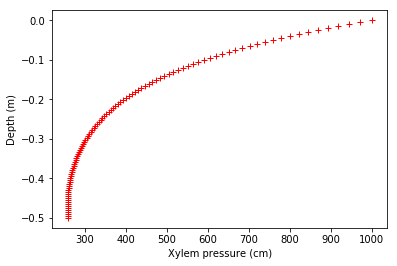

In [12]:
import matplotlib.pyplot as plt

g = 9.8                  # gravitational acceleration (m/s^2)   
rho = 1.e3               # density of water, (kg/m^3)      
ref = 1.e5

def toPa(ph): # cm pressure head to Pascal (kg/ (m s^2))
    return ref - ph/100. * rho * g

def toHead(pa): # Pascal (kg/ (m s^2)) to cm pressure head
    return -(pa-ref) * 100 / rho / g

p_ = read1D_vtp_data(path+"roots-00001.vtp", False)
z_ = np.linspace(0,-0.5,len(p_))
h_ = toHead(p_) 
plt.plot(h_,z_, "r+")
plt.ylabel("Depth (m)")
plt.xlabel("Xylem pressure (cm)")
plt.show()
